In [ ]:
!pip install pycountry
!pip install geopandas descartes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 53.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pycountry: filename=pycountry-22.3.5-py2.py3-none-any.whl size=10681832 sha256=b49fa7fa4e0ba7d92c680a2cc141cf1608fb25027e3db926a87192418302bc0a
  Stored in directory: /root/.cache/pip/wheels/03/57/cc/290c5252ec97a6d78d36479a3c5e5ecc76318afcb241ad9dbe
Successfully built pycountry


In [ ]:
#Import libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import sqlite3
import pycountry
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm

Functions for Analysis

In [ ]:
def analyze_top_categorical_distribution(df, categorical_column, top_n=10):
    """
    Analyzes the top N distribution of a categorical column in a DataFrame.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - categorical_column: str, the name of the categorical column to analyze.
    - top_n: int, the number of top categories to display (default is 10).

    Returns:
    - A bar plot showing the count of occurrences for the top N categories.
    - A pandas Series with the count of occurrences for the top N categories.
    """
    # Count the number of occurrences for each category and select the top N
    category_counts = df[categorical_column].value_counts().nlargest(top_n)

    # Plot the distribution of the top N categories
    plt.figure(figsize=(10, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title(f'Top {top_n} Distribution of {categorical_column}')
    plt.xlabel(categorical_column)
    plt.ylabel('Number of Occurrences')
    plt.xticks(rotation=45)  # Rotate the x labels for better readability
    plt.show()

    return category_counts

Function for date conversion

In [ ]:
def preprocess_datetime(df, datetime_column):
    """
    Converts a column to datetime, and creates two new columns: one for the hour of the day
    and one for the name of the day of the week.

    Parameters:
    - df: pandas.DataFrame containing the data.
    - datetime_column: str, the name of the column with datetime information.

    Returns:
    - The DataFrame with the new columns added.
    """
    # Convert the column to datetime
    df[datetime_column] = pd.to_datetime(df[datetime_column])

    # Extract the hour of the day
    df['hour_of_day'] = df[datetime_column].dt.hour

    # Extract the day of the week
    df['day_of_week'] = df[datetime_column].dt.day_name()

    return df

Function for geographical analysis

In [ ]:
def plot_choropleth(df, value_column, title, legend_label):
    # Convert the Series to DataFrame for merging
    data_df = df.reset_index()
    data_df.columns = ['country_code', value_column]

    # Load a world map shapefile or GeoJSON
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Function to convert alpha-2 country codes to alpha-3
    def convert_alpha2_to_alpha3(alpha_2_code):
        try:
            return pycountry.countries.get(alpha_2=alpha_2_code).alpha_3
        except:
            return None

    # Convert the country codes in the DataFrame
    data_df['country_code_alpha_3'] = data_df['country_code'].apply(convert_alpha2_to_alpha3)

    # Merge the world map with the DataFrame
    world = world.merge(data_df, left_on='iso_a3', right_on='country_code_alpha_3', how='left')

    # Handle zero and NaN values
    world[value_column] = world[value_column].replace(0, np.nan)  # Replace 0 with NaN
    world[value_column] = world[value_column].fillna(0)  # Now replace NaN (including former zeros) with 0 for plotting

    # Plot the map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)

    # Define the logarithmic scale
    # We add a small value to avoid taking the log of zero
    vmin = world[value_column][world[value_column] > 0].min()
    vmax = world[value_column].max()
    norm = LogNorm(vmin=vmin, vmax=vmax)

    # Plot countries with data using logarithmic scale
    world[world[value_column] > 0].plot(column=value_column, ax=ax, legend=True, cax=cax, cmap='RdYlGn',
                                         legend_kwds={'label': legend_label},
                                         norm=norm)

    # Plot countries with no data or zero values in gray
    world[world[value_column] == 0].plot(ax=ax, color='gray')

    # Remove axis
    ax.set_axis_off()

    # Set a title
    ax.set_title(title, fontdict={'fontsize': '20', 'fontweight' : '3'})

    # Show the map
    plt.show()


# **Clash Royale Data Analysis**

In [ ]:
#Connect to GitHub for faster access
!git clone https://github.com/melihkurtaran/Clash_Royale.git

Cloning into 'Clash_Royale'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 3 (delta 0), pack-reused 0
Receiving objects: 100% (3/3), 18.87 MiB | 16.35 MiB/s, done.


In [ ]:
# Connect to the SQLite database file
connection = sqlite3.connect('Clash_Royale/sample.sqlite')  # Replace with your database file path
cursor = connection.cursor()

# Run the SQL Query to get table names
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

# Fetch all the table names
table_names = cursor.fetchall()

# Print the table names
for table in table_names:
    print(table[0])

# Close the cursor and connection
cursor.close()
connection.close()


account
iap_purchase
account_date_session


In [ ]:
import sqlite3
import pandas as pd

# Connect to the SQLite database file
connection = sqlite3.connect('Clash_Royale/sample.sqlite')

# Get table names
cursor = connection.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
table_names = cursor.fetchall()
cursor.close()

# Create dataframes for each table
dataframes = {}
for table in table_names:
    table_name = table[0]
    query = f"SELECT * FROM {table_name};"
    dataframe = pd.read_sql_query(query, connection)
    dataframes[table_name] = dataframe

# Close the connection
connection.close()

In [ ]:
dataframes['account']

,account_id,created_time,created_device,created_platform,country_code,created_app_store_id
0,13514010,2016-03-02 17:11:00.332,"iPhone6,2",iOS,GB,1
1,4308483975,2016-03-02 20:57:46.14,MIDC147PJ,Android,FR,2
2,17193137415,2016-03-02 13:52:16.735,SM-G360F,Android,IT,2
3,21488104920,2016-03-02 12:43:27.899,H60-L01,Android,CN,8
4,21488107995,2016-03-02 17:20:12.145,GT-I9500,Android,RU,2
...,...,...,...,...,...,...
112787,51554039942,2016-08-07 13:32:49.115,KOPO L128,Android,CN,4
112788,51554090637,2016-08-11 22:20:27.192,SM-G3608,Android,CN,15
112789,51554102314,2016-08-12 21:10:20.742,"iPhone8,4",iOS,US,1
112790,51554116380,2016-08-14 01:37:13.821,SM-G935F,Android,HR,2


In [ ]:
dataframes['iap_purchase']

,account_id,created_time,package_id_hash,iap_price_usd_cents,app_store_id
0,30077202816,2016-03-26 23:59:59.355,ae0253c27c34edd1ab4fe21d6bfc91f8,739,0
1,30077202816,2016-05-31 11:24:37.283,dd4c1bda4f2c904075fb2fbfcf30f30e,369,0
2,21487283560,2016-02-13 03:40:28.644,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
3,21487152816,2016-02-28 00:53:26.678,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
4,8602037685,2016-02-11 01:03:04.727,99a9e0e63efa2fdce8fc8de74c66cea9,184,0
...,...,...,...,...,...
9904,51552698769,2016-07-23 03:25:58.87,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
9905,51552698769,2016-07-25 05:57:33.827,99a9e0e63efa2fdce8fc8de74c66cea9,184,1
9906,51552698769,2016-11-14 01:01:11.202,efd2eebfdc98b55f9e6b45915d56f7ac,36,1
9907,51552698769,2016-12-02 13:43:30.761,efd2eebfdc98b55f9e6b45915d56f7ac,36,1


In [ ]:
dataframes['account_date_session']

,account_id,date,session_count,session_duration_sec
0,68730811144,2016-01-01,1,47
1,68730812806,2016-01-01,1,204
2,68730829426,2016-01-01,12,4703
3,68730829426,2016-01-02,9,4676
4,68730829426,2016-01-03,9,2271
...,...,...,...,...
1698969,55850490316,2016-12-30,1,392
1698970,55850515956,2016-12-30,1,564
1698971,55850515956,2016-12-31,9,3268
1698972,55850519336,2016-12-31,9,4043


Naming them as df_

In [ ]:
df_account = dataframes['account']
df_iap_purchase = dataframes['iap_purchase']
df_account_date_session = dataframes['account_date_session']

## Account Dataset Analysis

In [ ]:
print(df_account.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112792 entries, 0 to 112791
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   account_id            112792 non-null  object
 1   created_time          112792 non-null  object
 2   created_device        112792 non-null  object
 3   created_platform      112792 non-null  object
 4   country_code          112685 non-null  object
 5   created_app_store_id  112792 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 5.2+ MB
None


In [ ]:
print(df_account.isnull().sum())

account_id                0
created_time              0
created_device            0
created_platform          0
country_code            107
created_app_store_id      0
dtype: int64


In [ ]:
df_account = preprocess_datetime(df_account, 'created_time')

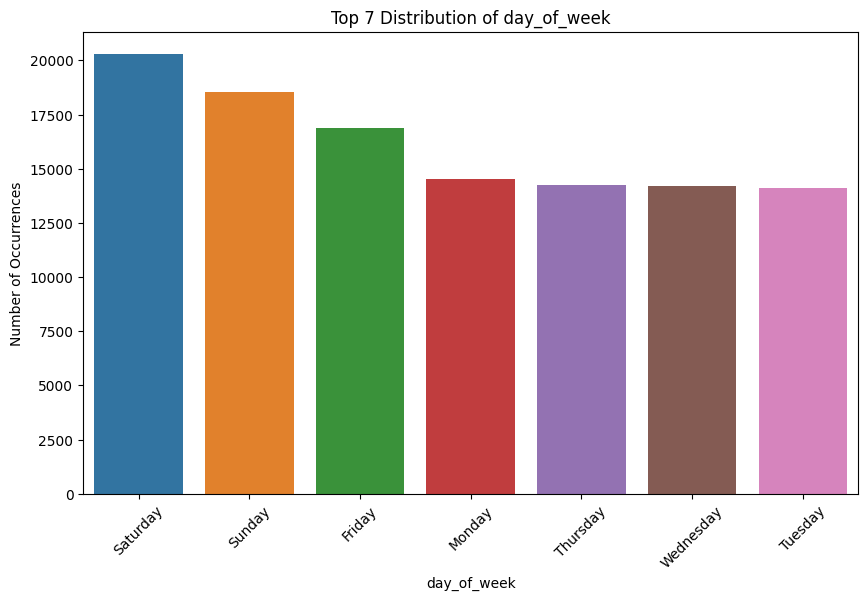

Saturday     20303
Sunday       18549
Friday       16866
Monday       14501
Thursday     14247
Wednesday    14217
Tuesday      14109
Name: day_of_week, dtype: int64


In [ ]:
# Day of week
day_of_week_counts = analyze_top_categorical_distribution(df_account, 'day_of_week', 7)
print(day_of_week_counts)

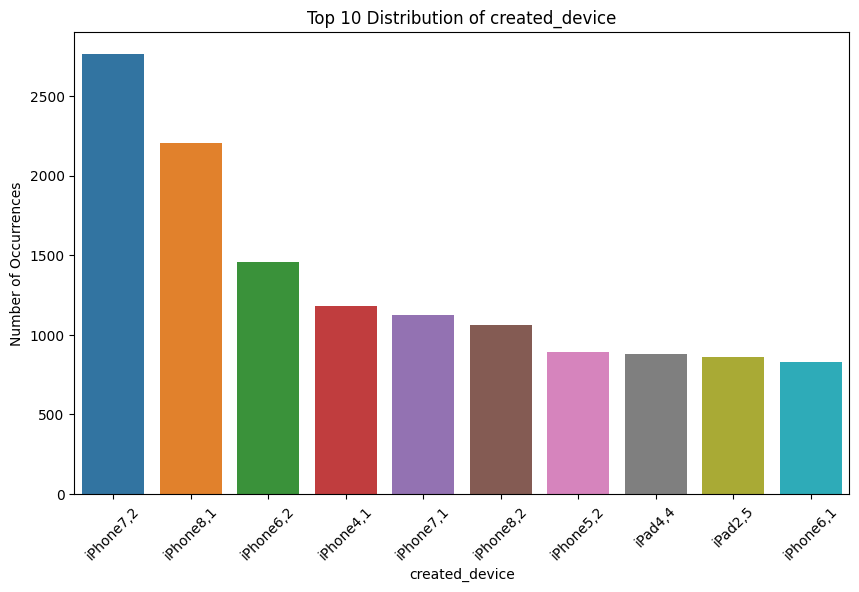

iPhone7,2    2764
iPhone8,1    2206
iPhone6,2    1456
iPhone4,1    1182
iPhone7,1    1122
iPhone8,2    1059
iPhone5,2     892
iPad4,4       880
iPad2,5       861
iPhone6,1     832
Name: created_device, dtype: int64


In [ ]:
device_counts = analyze_top_categorical_distribution(df_account, 'created_device')
print(device_counts)

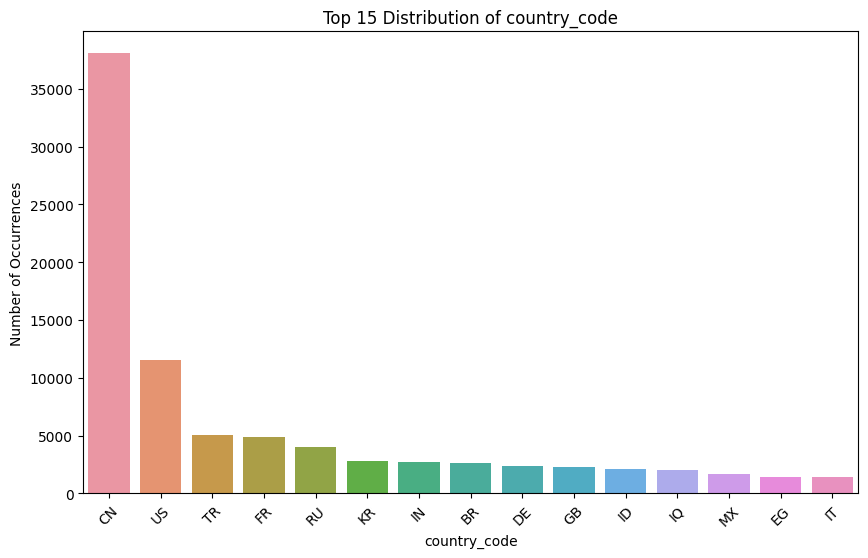

CN    38044
US    11553
TR     5060
FR     4843
RU     4055
KR     2817
IN     2719
BR     2655
DE     2353
GB     2255
ID     2111
IQ     2050
MX     1682
EG     1453
IT     1440
Name: country_code, dtype: int64


In [ ]:
# Top 15 Countries
country_counts = analyze_top_categorical_distribution(df_account, 'country_code',15)
print(country_counts)

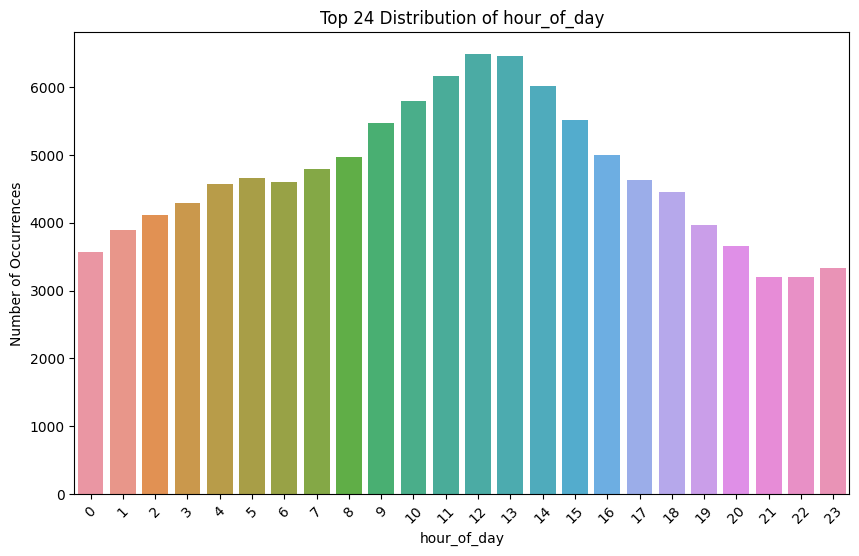

12    6485
13    6453
11    6167
14    6008
10    5788
15    5511
9     5470
16    4991
8     4966
7     4798
5     4659
17    4637
6     4594
4     4573
18    4448
3     4293
2     4120
19    3971
1     3891
20    3663
0     3571
23    3338
22    3202
21    3195
Name: hour_of_day, dtype: int64


In [ ]:
# Analyzing all 24 hours
hour_of_day_counts = analyze_top_categorical_distribution(df_account, 'hour_of_day',24)
print(hour_of_day_counts)

## iap_purchase Dataset Analysis

In [ ]:
print(df_iap_purchase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9909 entries, 0 to 9908
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   account_id           9909 non-null   object
 1   created_time         9909 non-null   object
 2   package_id_hash      9909 non-null   object
 3   iap_price_usd_cents  9909 non-null   int64 
 4   app_store_id         9909 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 387.2+ KB
None


In [ ]:
print(df_iap_purchase.isnull().sum())

account_id             0
created_time           0
package_id_hash        0
iap_price_usd_cents    0
app_store_id           0
dtype: int64


In [ ]:
df_iap_purchase = preprocess_datetime(df_iap_purchase, 'created_time')

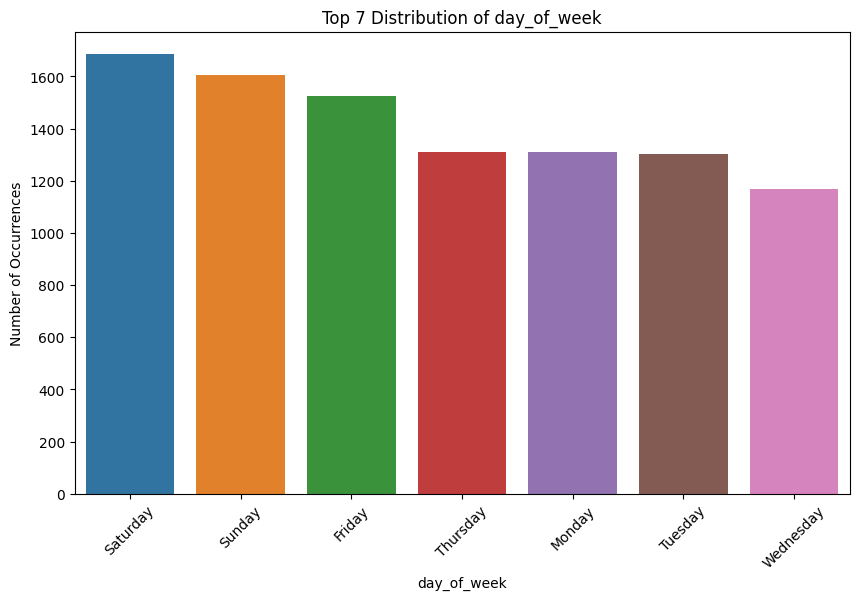

Saturday     1687
Sunday       1605
Friday       1524
Thursday     1312
Monday       1310
Tuesday      1304
Wednesday    1167
Name: day_of_week, dtype: int64


In [ ]:
day_of_week_counts = analyze_top_categorical_distribution(df_iap_purchase, 'day_of_week', 7)
print(day_of_week_counts)

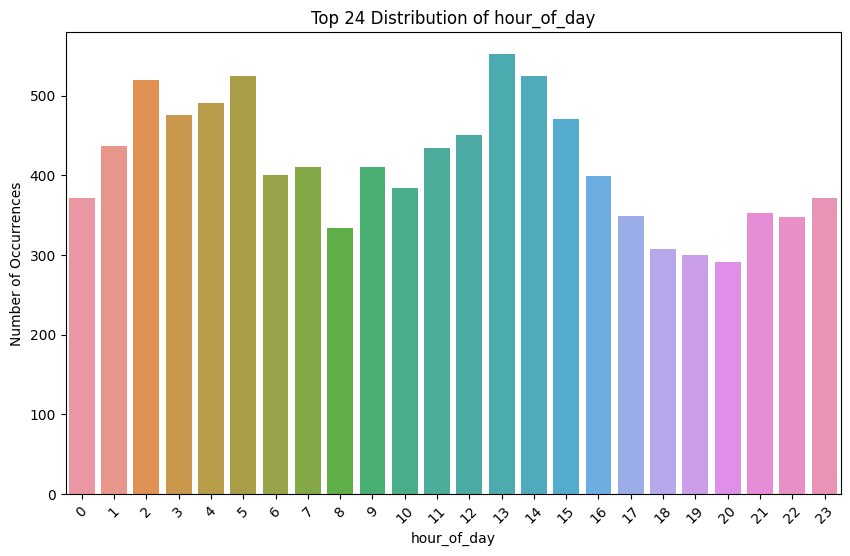

13    552
5     524
14    524
2     520
4     491
3     476
15    470
12    451
1     437
11    434
9     411
7     411
6     400
16    399
10    384
0     372
23    371
21    353
17    349
22    348
8     334
18    307
19    300
20    291
Name: hour_of_day, dtype: int64


In [ ]:
hour_of_day_counts = analyze_top_categorical_distribution(df_iap_purchase, 'hour_of_day',24)
print(hour_of_day_counts)

In [ ]:
df_iap_purchase['iap_price_usd_cents'].unique()

array([ 739,  369,  184,   36, 1849,  110, 3699])

Since there are only 7 unique values of iap purchases, I can plot them as categorical values

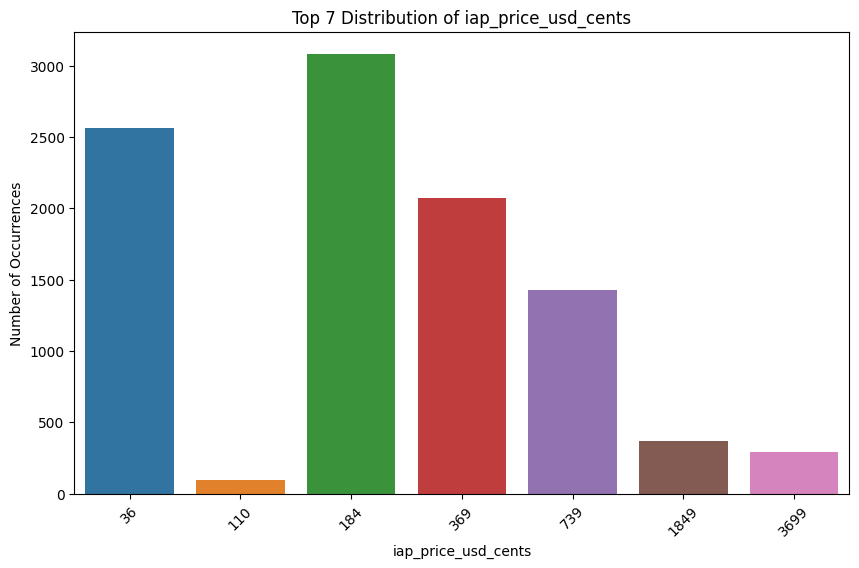

184     3084
36      2566
369     2073
739     1426
1849     369
3699     292
110       99
Name: iap_price_usd_cents, dtype: int64


In [ ]:
price_counts = analyze_top_categorical_distribution(df_iap_purchase, 'iap_price_usd_cents', 7)
print(price_counts)

## account_date_session Dataset Analysis

In [ ]:
print(df_account_date_session.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1698974 entries, 0 to 1698973
Data columns (total 4 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   account_id            object
 1   date                  object
 2   session_count         int64 
 3   session_duration_sec  int64 
dtypes: int64(2), object(2)
memory usage: 51.8+ MB
None


In [ ]:
print(df_account_date_session.isnull().sum())

account_id              0
date                    0
session_count           0
session_duration_sec    0
dtype: int64


In [ ]:
df_account_date_session = preprocess_datetime(df_account_date_session, 'date')

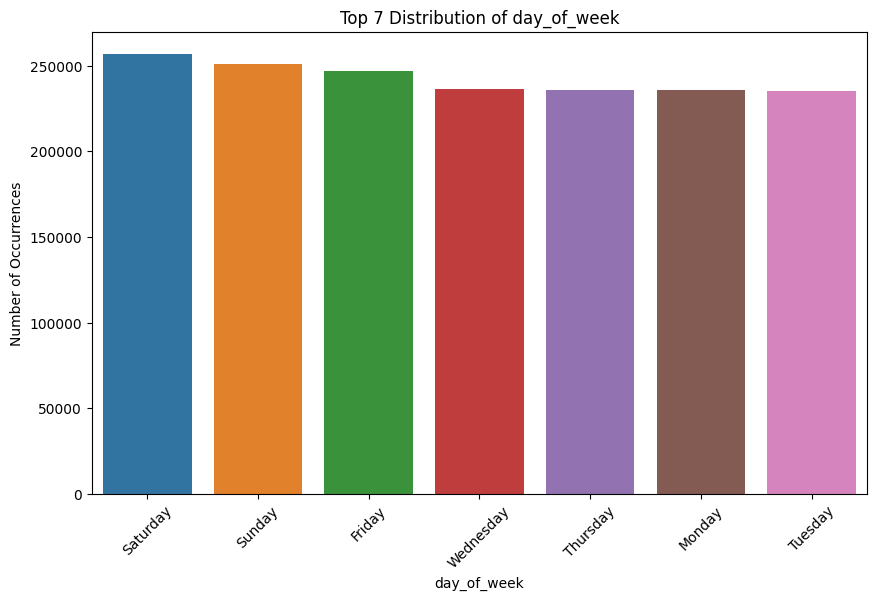

Saturday     256971
Sunday       251177
Friday       246896
Wednesday    236462
Thursday     236080
Monday       235992
Tuesday      235396
Name: day_of_week, dtype: int64


In [ ]:
day_of_week_counts = analyze_top_categorical_distribution(df_account_date_session, 'day_of_week', 7)
print(day_of_week_counts)

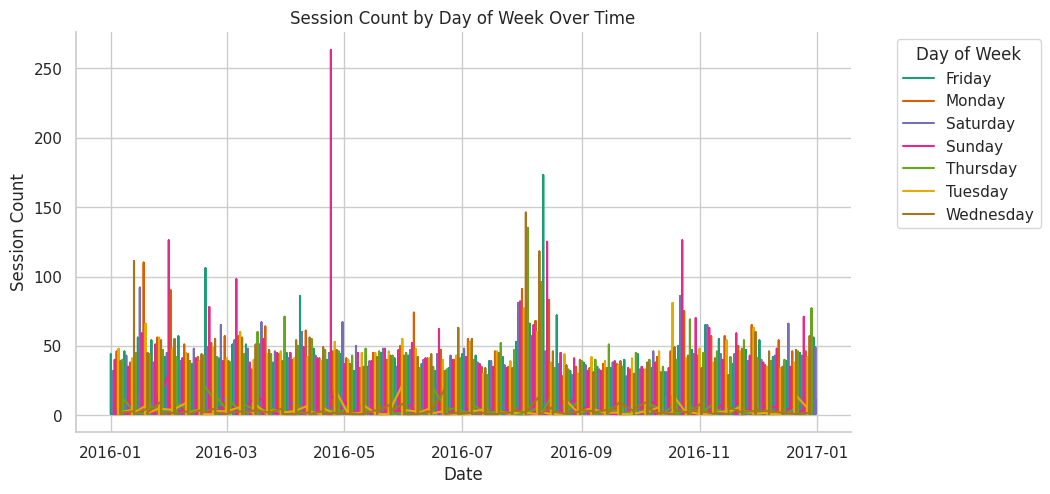

In [ ]:
sns.set_theme(style="whitegrid")

def plot_time_series(series, series_name, series_index, palette):
    """
    Plot a time series.

    Parameters:
    - series: pandas.Series, the time series data to plot.
    - series_name: str, the name of the series to use as the label.
    - series_index: int, the index of the series for color selection.
    - palette: list, a list of colors for the plot.
    """
    xs = series['date']
    ys = series['session_count']
    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

dataframe['date'] = pd.to_datetime(dataframe['date'])

# Sort the dataframe by date
df_sorted = dataframe.sort_values('date', ascending=True)

# Define the color palette
palette = sns.color_palette('Dark2', n_colors=df_sorted['day_of_week'].nunique())

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(10, 5.2))

# Plot each series
for i, (series_name, series) in enumerate(df_sorted.groupby('day_of_week')):
    plot_time_series(series, series_name, i, palette)

# Set axis labels and title
ax.set_xlabel('Date')
ax.set_ylabel('Session Count')
ax.set_title('Session Count by Day of Week Over Time')

# Add the legend outside of the plot
ax.legend(title='Day of Week', bbox_to_anchor=(1.05, 1), loc='upper left')

# Despine for a cleaner look
sns.despine(fig=fig, ax=ax)

# Show the plot
plt.show()

# Geographical Analysis

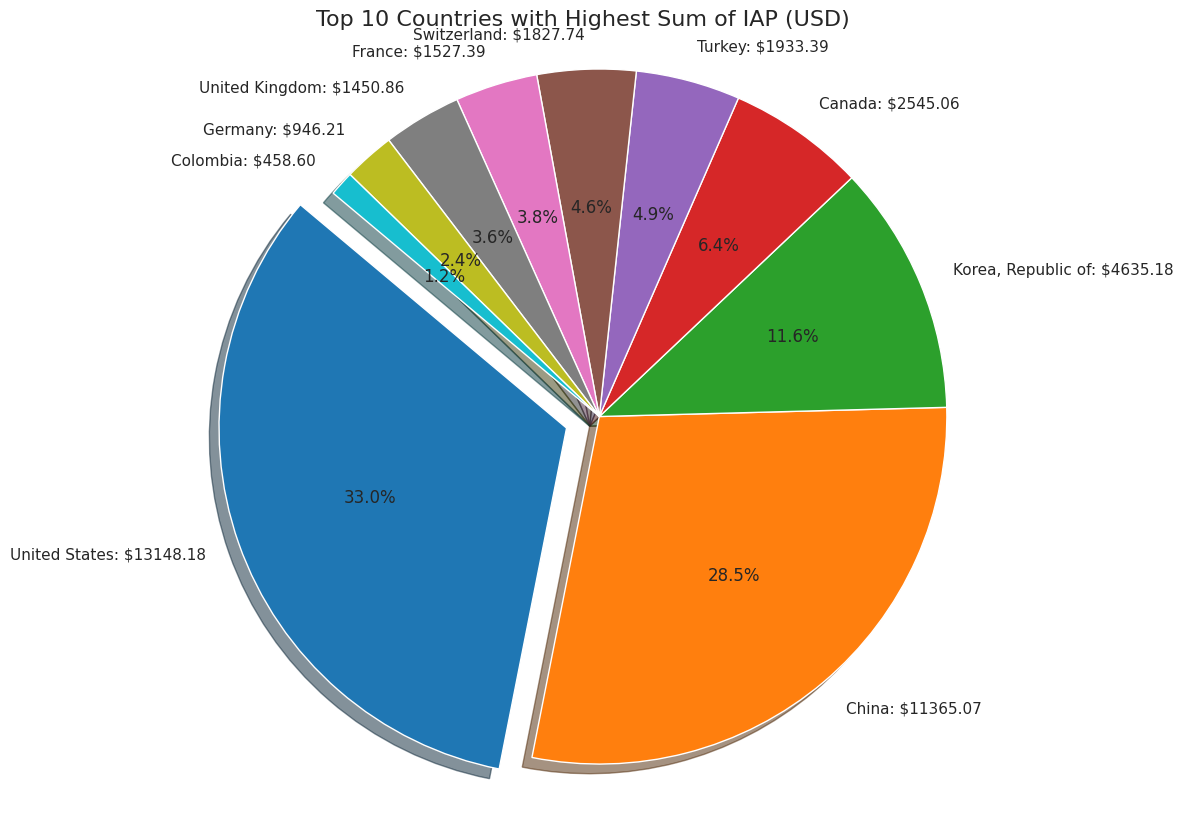

In [ ]:
# Merge the two dataframes on 'account_id'
merged_df = pd.merge(df_iap_purchase, df_account, on='account_id', suffixes=('_purchase', '_account'))

# Group by 'country_code' from the account dataframe and sum the 'iap_price_usd_cents'
country_iap_sums = merged_df.groupby('country_code')['iap_price_usd_cents'].sum()

# Convert cents to dollars
country_iap_sums = country_iap_sums / 100

df_money_spent = country_iap_sums.reset_index(name='total_money')

# If you want to keep it as a Series with the country codes as the index (like the one you've shown), then you don't need to reset the index
# Just rename the Series for clarity
df_money_spent = country_iap_sums.rename('total_money')

# Sort the sums in descending order and take the top 10
top_countries = country_iap_sums.sort_values(ascending=False).head(10)

# Convert two-letter country codes to country names using pycountry
def get_country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return "Unknown"

# Apply the conversion to the index
top_countries.index = top_countries.index.map(get_country_name)

# Define the explode values for the slices (e.g., explode the first slice)
explode_values = (0.1,) + (0,) * (len(top_countries) - 1)  # Only explode the first slice

# Define a color palette
colors = plt.cm.tab10.colors  # This is a colormap from matplotlib

# Create labels that include both the country name and the amount in dollars
labels = [f'{country}: ${amount:.2f}' for country, amount in zip(top_countries.index, top_countries)]

# Plotting the pie chart
plt.figure(figsize=(12, 10))  # Increase the figure size
plt.pie(top_countries, labels=labels, autopct='%1.1f%%', startangle=140, explode=explode_values, colors=colors, shadow=True)

# Set the title with an increased font size
plt.title('Top 10 Countries with Highest Sum of IAP (USD)', fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot with improvements
plt.show()


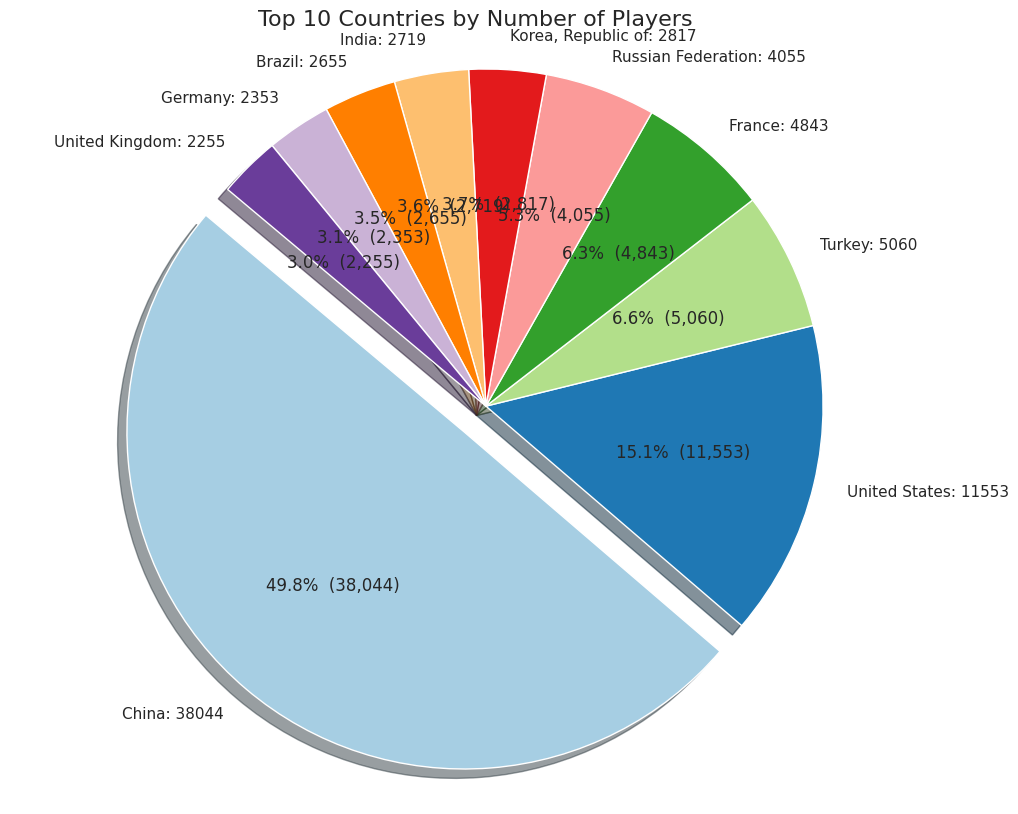

In [ ]:
# Count the number of unique account IDs per country
country_player_counts = df_account.groupby('country_code')['account_id'].nunique()

# Sort the counts in descending order and take the top 10
top_countries_by_players = country_player_counts.sort_values(ascending=False).head(10)

# Convert two-letter country codes to country names using pycountry
def get_country_name(country_code):
    try:
        return pycountry.countries.get(alpha_2=country_code).name
    except:
        return "Unknown"

# Apply the conversion to the index
top_countries_by_players.index = top_countries_by_players.index.map(get_country_name)

# Define the explode values for the slices (e.g., explode the first slice)
explode_values = (0.1,) + (0,) * (len(top_countries_by_players) - 1)  # Only explode the first slice

# Define a color palette
colors = plt.cm.Paired.colors  # This is a colormap from matplotlib

# Create labels that include both the country name and the number of players
labels = [f'{country}: {players}' for country, players in zip(top_countries_by_players.index, top_countries_by_players)]

# Plotting the pie chart
plt.figure(figsize=(12, 10))  # Increase the figure size
plt.pie(top_countries_by_players, labels=labels, autopct=lambda p: '{:.1f}%  ({:,.0f})'.format(p, p * sum(top_countries_by_players) / 100), startangle=140, explode=explode_values, colors=colors, shadow=True)

# Set the title with an increased font size
plt.title('Top 10 Countries by Number of Players', fontsize=16)

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot with improvements
plt.show()


<ipython-input-134-ad4c38132447>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


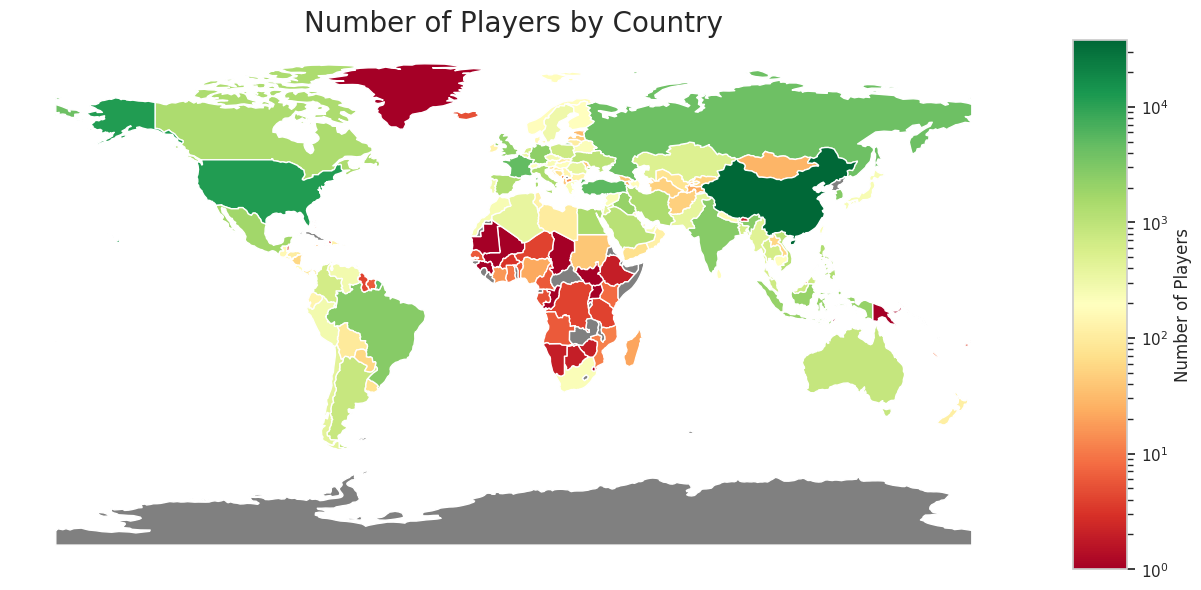

In [ ]:
plot_choropleth(country_player_counts, 'player_count', 'Number of Players by Country', 'Number of Players')

<ipython-input-134-ad4c38132447>:7: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


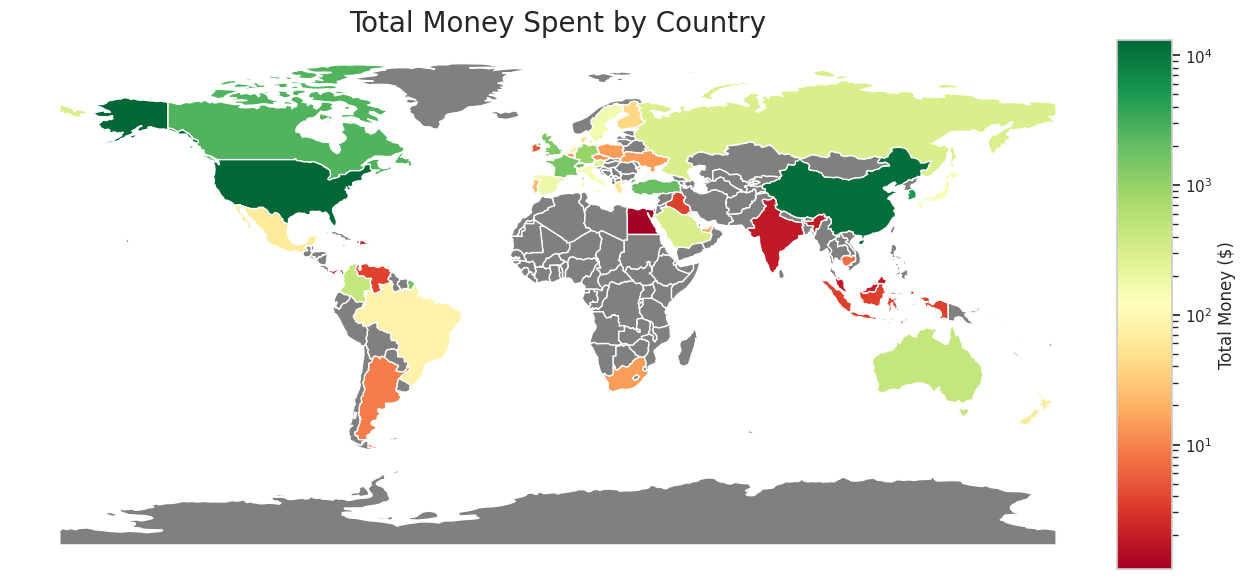

In [ ]:
plot_choropleth(df_money_spent, 'total_money', 'Total Money Spent by Country', 'Total Money ($)')

# DAU changes over time

In [ ]:
df_account_date_session

,account_id,date,session_count,session_duration_sec,hour_of_day,day_of_week
0,68730811144,2016-01-01,1,47,0,Friday
1,68730812806,2016-01-01,1,204,0,Friday
2,68730829426,2016-01-01,12,4703,0,Friday
3,68730829426,2016-01-02,9,4676,0,Saturday
4,68730829426,2016-01-03,9,2271,0,Sunday
...,...,...,...,...,...,...
1698969,55850490316,2016-12-30,1,392,0,Friday
1698970,55850515956,2016-12-30,1,564,0,Friday
1698971,55850515956,2016-12-31,9,3268,0,Saturday
1698972,55850519336,2016-12-31,9,4043,0,Saturday


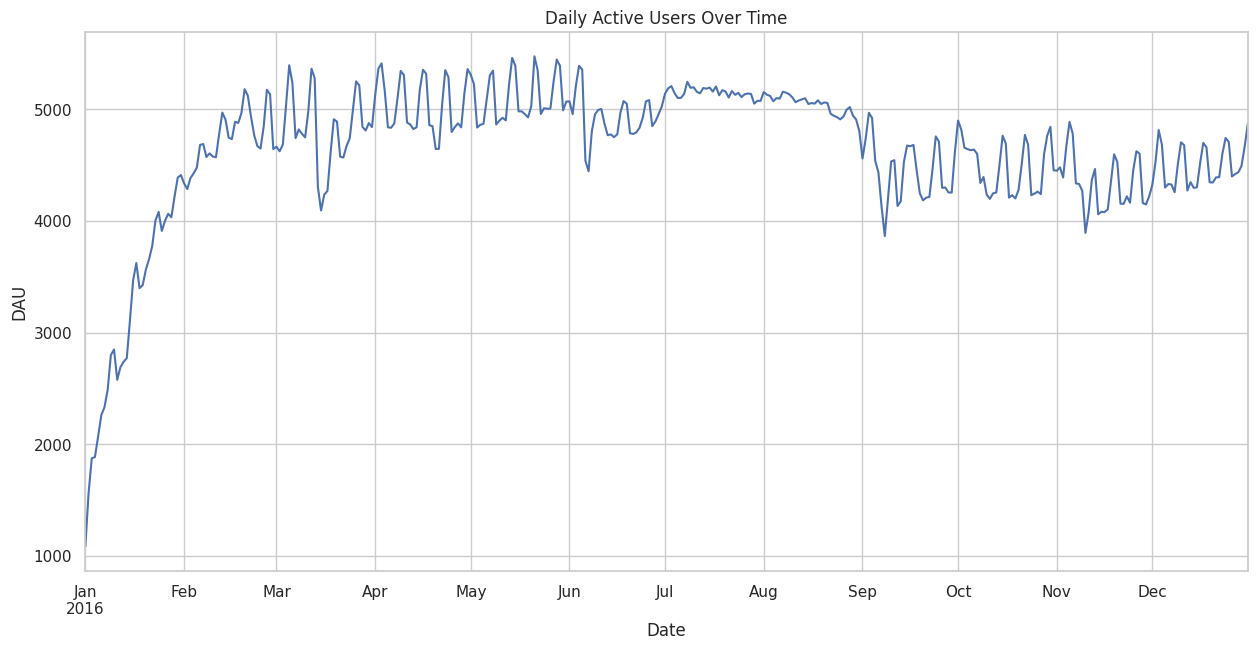

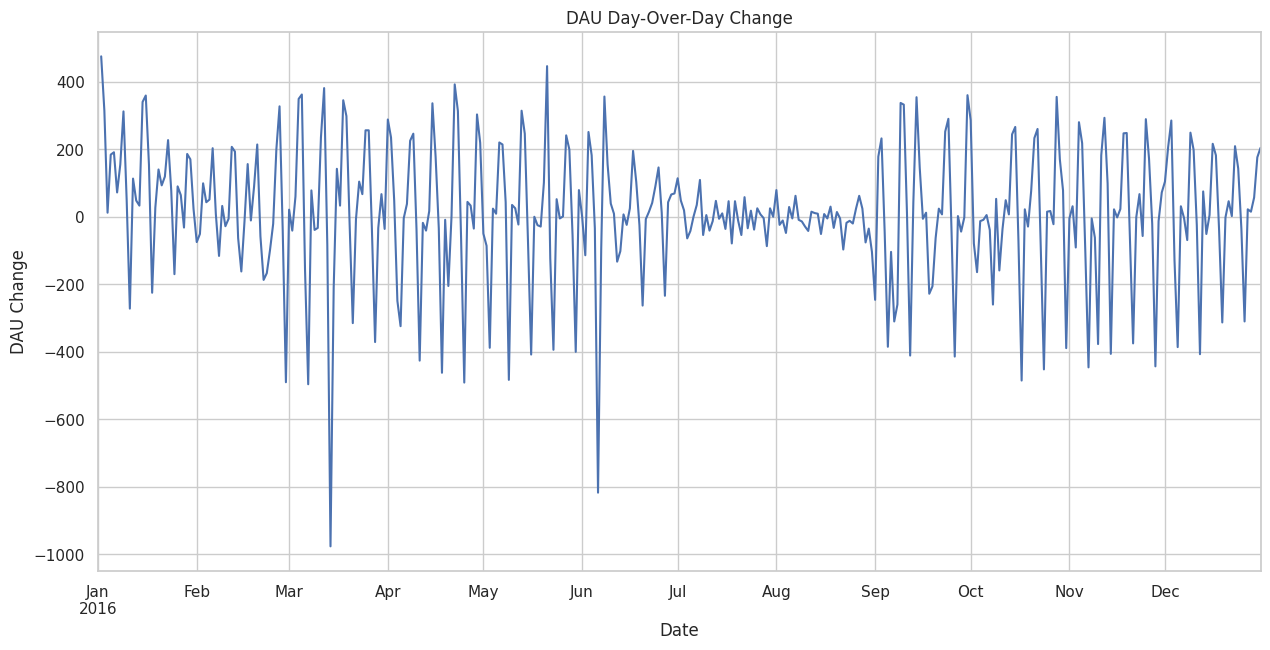

In [ ]:
# Aggregate DAU by counting unique account_ids for each date
dau = df_account_date_session.groupby('date')['account_id'].nunique()

# Create a DataFrame for the DAU
dau_df = pd.DataFrame(dau).rename(columns={'account_id': 'dau'})

# Calculate the day-over-day change in DAU
dau_df['dau_change'] = dau_df['dau'].diff()

# Plot the DAU over time
plt.figure(figsize=(15, 7))
dau_df['dau'].plot(title='Daily Active Users Over Time')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.grid(True)
plt.show()

# Plot the day-over-day change in DAU
plt.figure(figsize=(15, 7))
dau_df['dau_change'].plot(title='DAU Day-Over-Day Change')
plt.xlabel('Date')
plt.ylabel('DAU Change')
plt.grid(True)
plt.show()

It is clearly seen that during the summer holiday, all the days have similar number of active users however, during school times sunday and saturday have much higher number of active users. That shows that most of the active users are pupils.

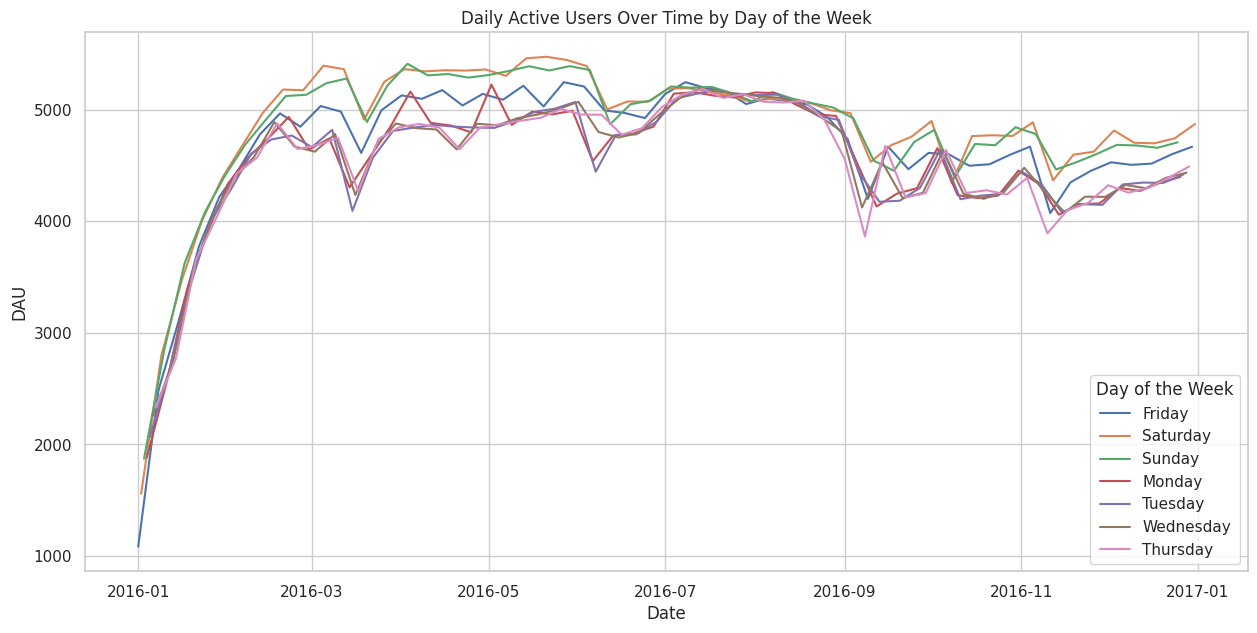

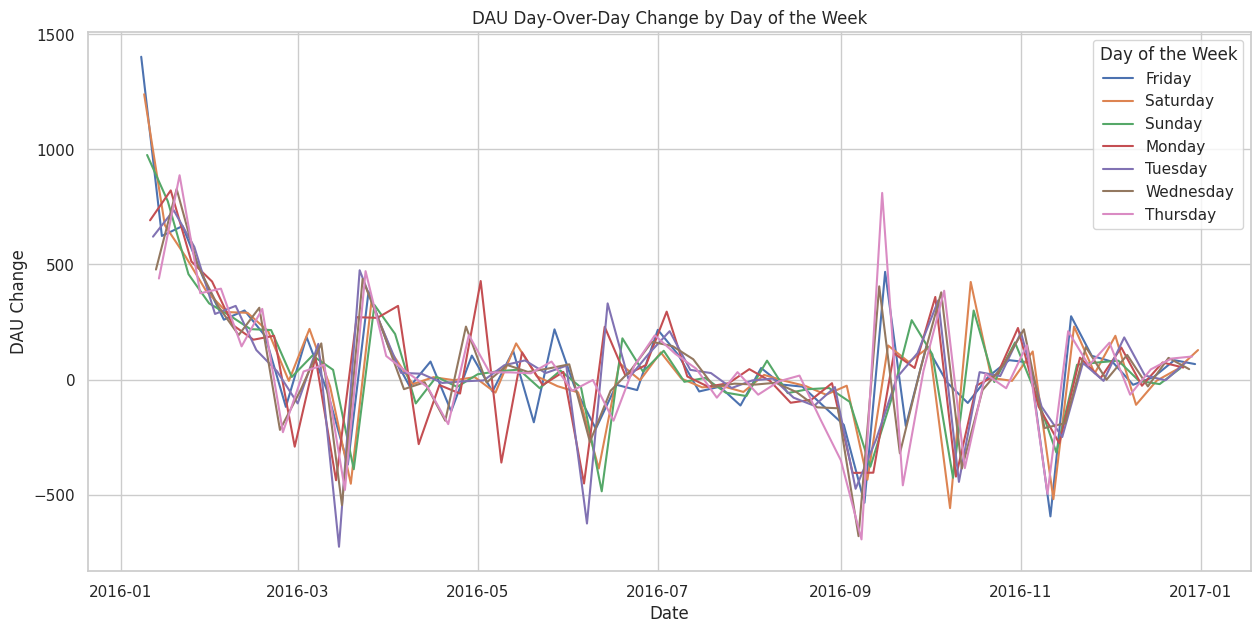

             count       mean         std    min   25%   50%     75%     max
day_of_week                                                                 
Friday        52.0  68.961538  302.383276 -595.0 -52.0  31.5  155.75  1403.0
Monday        51.0  49.313725  273.657047 -452.0 -46.0  33.0  207.00   822.0
Saturday      52.0  63.750000  285.481010 -559.0 -29.0  10.0  150.25  1240.0
Sunday        51.0  55.627451  252.326690 -486.0 -40.0  34.0  143.00   976.0
Thursday      51.0  42.392157  289.183684 -695.0 -57.5  35.0  146.50   888.0
Tuesday       51.0  46.137255  267.781480 -727.0 -11.5  28.0  141.50   736.0
Wednesday     51.0  42.686275  260.185971 -681.0 -47.5  43.0  160.50   828.0


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_account_date_session is your DataFrame
# Convert 'date' column to datetime type if it's not already
df_account_date_session['date'] = pd.to_datetime(df_account_date_session['date'])

# Extract day of the week from 'date' and create a new column
df_account_date_session['day_of_week'] = df_account_date_session['date'].dt.day_name()

# Aggregate DAU by counting unique account_ids for each date
dau = df_account_date_session.groupby(['date', 'day_of_week'])['account_id'].nunique().reset_index(name='dau')

# Calculate the day-over-day change in DAU for each day of the week
dau['dau_change'] = dau.groupby('day_of_week')['dau'].diff()

# Plot the DAU over time with a line for each day of the week
plt.figure(figsize=(15, 7))
sns.lineplot(data=dau, x='date', y='dau', hue='day_of_week')
plt.title('Daily Active Users Over Time by Day of the Week')
plt.xlabel('Date')
plt.ylabel('DAU')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()

# Plot the day-over-day change in DAU by day of the week
plt.figure(figsize=(15, 7))
sns.lineplot(data=dau, x='date', y='dau_change', hue='day_of_week')
plt.title('DAU Day-Over-Day Change by Day of the Week')
plt.xlabel('Date')
plt.ylabel('DAU Change')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()


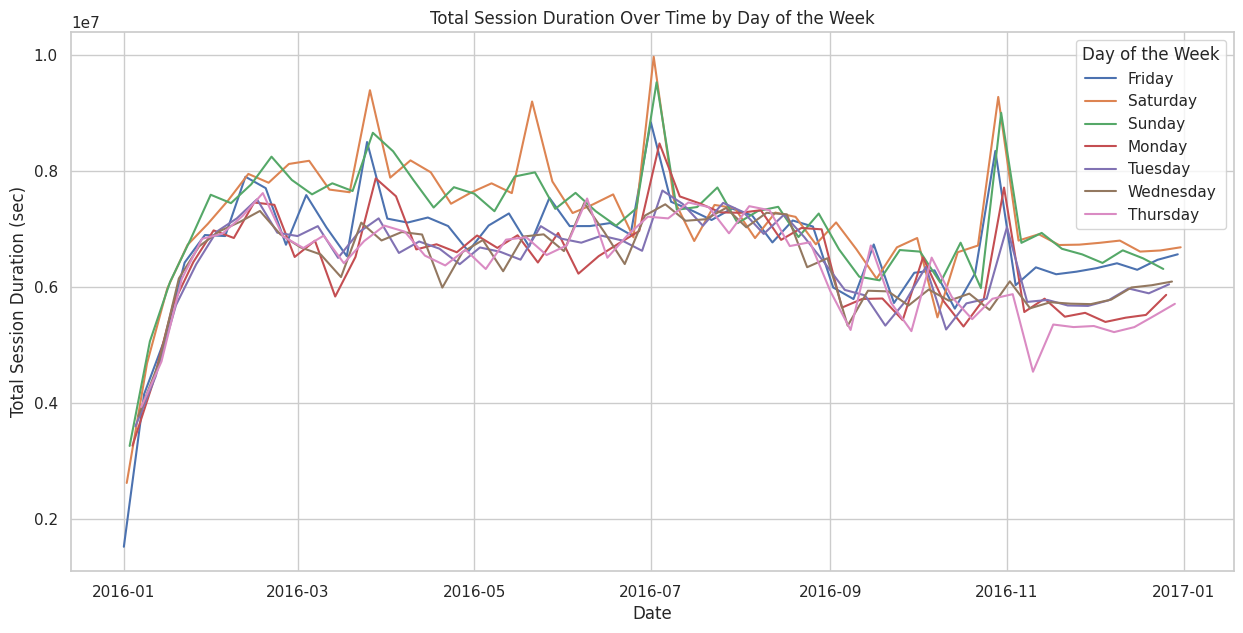

In [ ]:
# Extract day of the week from 'date' and create a new column
df_account_date_session['day_of_week'] = df_account_date_session['date'].dt.day_name()

# Aggregate DAU and total session duration by counting unique account_ids and summing session_duration_sec for each date
daily_stats = df_account_date_session.groupby(['date', 'day_of_week']).agg(
    dau=('account_id', 'nunique'),
    total_session_duration=('session_duration_sec', 'sum')
).reset_index()

# Calculate the day-over-day change in DAU and total session duration for each day of the week
daily_stats['dau_change'] = daily_stats.groupby('day_of_week')['dau'].diff()
daily_stats['session_duration_change'] = daily_stats.groupby('day_of_week')['total_session_duration'].diff()

# Plot the total session duration over time with a line for each day of the week
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_stats, x='date', y='total_session_duration', hue='day_of_week')
plt.title('Total Session Duration Over Time by Day of the Week')
plt.xlabel('Date')
plt.ylabel('Total Session Duration (sec)')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()


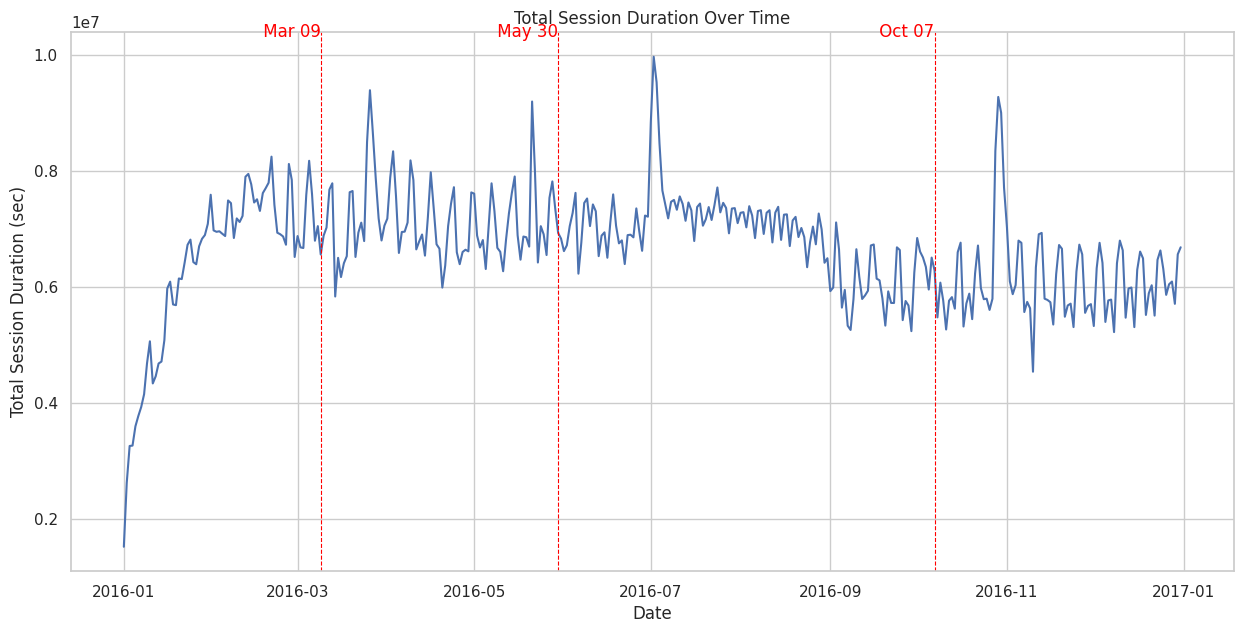

In [ ]:
# Aggregate total session duration by summing session_duration_sec for each date
daily_stats = df_account_date_session.groupby('date').agg(
    total_session_duration=('session_duration_sec', 'sum')
).reset_index()

# Plot the total session duration over time
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_stats, x='date', y='total_session_duration')

# Highlight the 9th of March and the 30th of May 2016
highlights = ['2016-03-09', '2016-05-30','2016-10-07']
for date in highlights:
    plt.axvline(x=pd.to_datetime(date), color='red', linestyle='--', linewidth=0.8)
    plt.text(pd.to_datetime(date), plt.gca().get_ylim()[1], ' ' + pd.to_datetime(date).strftime('%b %d'), color='red', ha='right', va='center')

plt.title('Total Session Duration Over Time')
plt.xlabel('Date')
plt.ylabel('Total Session Duration (sec)')
plt.grid(True)
plt.show()


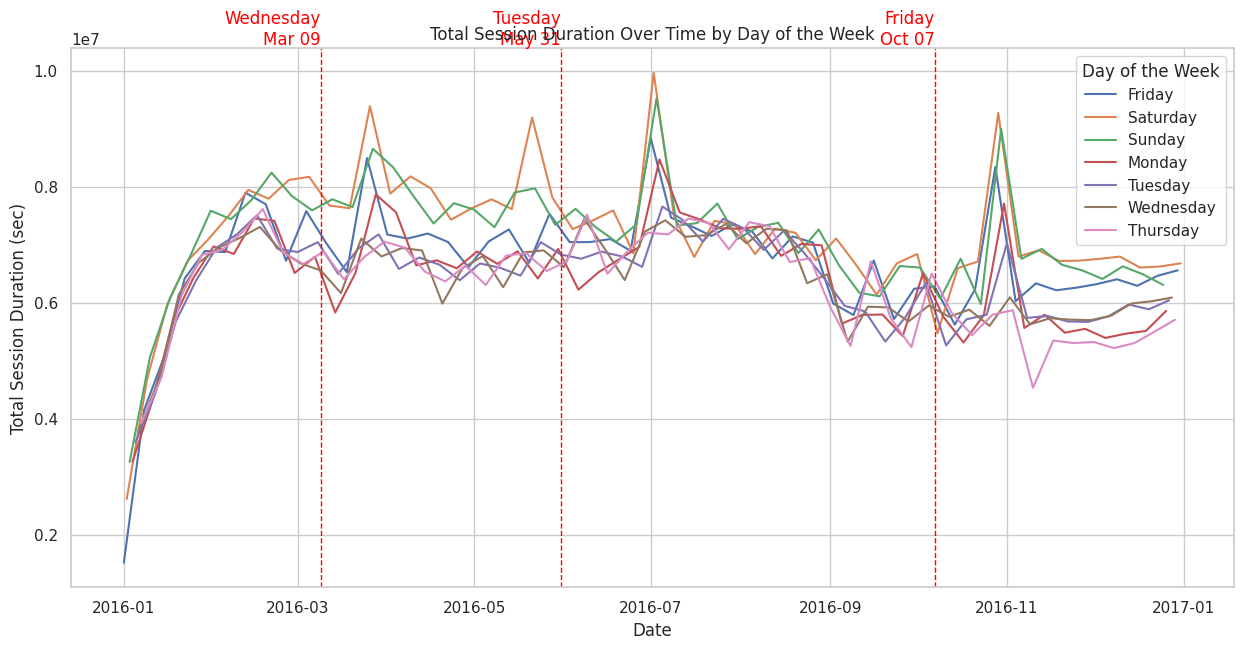

In [ ]:
# Extract day of the week from 'date' and create a new column
df_account_date_session['day_of_week'] = df_account_date_session['date'].dt.day_name()

# Aggregate DAU and total session duration by counting unique account_ids and summing session_duration_sec for each date
daily_stats = df_account_date_session.groupby(['date', 'day_of_week']).agg(
    dau=('account_id', 'nunique'),
    total_session_duration=('session_duration_sec', 'sum')
).reset_index()

# Calculate the day-over-day change in DAU and total session duration for each day of the week
daily_stats['dau_change'] = daily_stats.groupby('day_of_week')['dau'].diff()
daily_stats['session_duration_change'] = daily_stats.groupby('day_of_week')['total_session_duration'].diff()

# Plot the total session duration over time with a line for each day of the week
plt.figure(figsize=(15, 7))
sns.lineplot(data=daily_stats, x='date', y='total_session_duration', hue='day_of_week', legend='full')

highlight_dates = ['2016-03-09', '2016-05-31','2016-10-07']
for date_str in highlight_dates:
    date = pd.to_datetime(date_str)
    plt.axvline(x=date, color='red', linestyle='--', linewidth=1)

    # Find the day of the week for the highlighted date
    day_of_week = daily_stats[daily_stats['date'] == date]['day_of_week'].values[0]
    plt.text(date, plt.gca().get_ylim()[1], f'{day_of_week}\n{date.strftime("%b %d")}', color='red', ha='right', va='bottom')

plt.title('Total Session Duration Over Time by Day of the Week')
plt.xlabel('Date')
plt.ylabel('Total Session Duration (sec)')
plt.legend(title='Day of the Week')
plt.grid(True)
plt.show()


# Part 2

The rest of the study can be found in part 2 notebook:


https://colab.research.google.com/drive/11FqREGZBlH_Duj06AHqZbclkcM2HcznQ?usp=sharing